# Week 11

## Kinnick Fox
## DSC530

All code before Exercise 12-1 is written by Allen B. Downey

In [10]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [11]:
import thinkstats2
import thinkplot

In [12]:
import numpy as np
import pandas as pd
import survival

In [13]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [14]:
from collections import Counter


def EstimateHazardFunction(complete, ongoing, label="", verbose=False):
    """Estimates the hazard function by Kaplan-Meier.

    http://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator

    complete: list of complete lifetimes
    ongoing: list of ongoing lifetimes
    label: string
    verbose: whether to display intermediate results
    """
    if np.sum(np.isnan(complete)):
        raise ValueError("complete contains NaNs")
    if np.sum(np.isnan(ongoing)):
        raise ValueError("ongoing contains NaNs")

    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)

    ts = list(hist_complete | hist_ongoing)
    ts.sort()

    at_risk = len(complete) + len(ongoing)

    lams = pd.Series(index=ts, dtype=float)
    for t in ts:
        ended = hist_complete[t]
        censored = hist_ongoing[t]

        lams[t] = ended / at_risk
        if verbose:
            print(t, at_risk, ended, censored, lams[t])
        at_risk -= ended + censored

    return survival.HazardFunction(lams, label=label)

In [15]:
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/1995FemRespData.dat.gz"
)
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemRespSetup.dct"
)
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemResp.dat.gz"
)

In [16]:
resp5 = survival.ReadFemResp1995()
resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()

In [25]:
resps = [resp5, resp6, resp7]

In [17]:
def AddLabelsByDecade(groups, **options):
    """Draws fake points in order to add labels to the legend.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for name, _ in groups:
        label = "%d0s" % name
        thinkplot.Plot([15], [1], label=label, **options)


def EstimateMarriageSurvivalByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for _, group in groups:
        _, sf = EstimateMarriageSurvival(group)
        thinkplot.Plot(sf, **options)


def PlotResampledByDecade(resps, iters=11, predict_flag=False, omit=None):
    """Plots survival curves for resampled data.

    resps: list of DataFrames
    iters: number of resamples to plot
    predict_flag: whether to also plot predictions
    """
    for i in range(iters):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby("decade")

        if omit:
            groups = [(name, group) for name, group in groups if name not in omit]

        # TODO: refactor this to collect resampled estimates and
        # plot shaded areas
        if i == 0:
            AddLabelsByDecade(groups, alpha=0.7)

        if predict_flag:
            PlotPredictionsByDecade(groups, alpha=0.1)
            EstimateMarriageSurvivalByDecade(groups, alpha=0.1)
        else:
            EstimateMarriageSurvivalByDecade(groups, alpha=0.2)

## Exercises

**Exercise:**    In NSFG Cycles 6 and 7, the variable `cmdivorcx` contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months.

Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.

Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.

Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [18]:
def CleanData(resp):
    """Cleans respondent data.

    resp: DataFrame
    """
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    resp["notdivorced"] = resp.cmdivorcx.isnull().astype(int)
    resp["duration"] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp["durationsofar"] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime("1899-12-15")
    dates = [month0 + pd.DateOffset(months=cm) for cm in resp.cmbirth]
    resp["decade"] = (pd.DatetimeIndex(dates).year - 1900) // 10

In [19]:
CleanData(resp6)
married6 = resp6[resp6.evrmarry == 1]

CleanData(resp7)
married7 = resp7[resp7.evrmarry == 1]

In [20]:
def EstSurv(data):
    complete = data[data.notdivorced == 0].duration.dropna()
    ongoing = data[data.notdivorced == 1].durationsofar.dropna()

    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

In [21]:
def EstSurvivalDec(groups, **options):
    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        _, sf = EstSurv(group)
        thinkplot.Plot(sf, **options)

In [22]:
def ResampleDivorceCurve(data):
    for _ in range(11):
        samps = [thinkstats2.ResampleRowsWeighted(data) for data in resps]
        samp = pd.concat(samps, ignore_index = True)
        PlotDivorceCurveDecade(samp, alpha = 0.2)

    thinkplot.Show(xlabel="Length of Marriage")

In [23]:
def ResampleDivorceCurveDec(data):
    for i in range(41):
        samps = [thinkstats2.ResampleRowsWeighted(data) for data in resps]
        samp = pd.concat(samps, ignore_index = True)
        decades = samp.groupby("decade")
        if i == 0:
            survival.AddLabelsByDecade(decades, alpha = 0.2)

        EstSurvivalDec(decades, alpha = 0.2)

    thinkplot.Config(xlabel="Length of Marriage", ylabel="Percent Married")

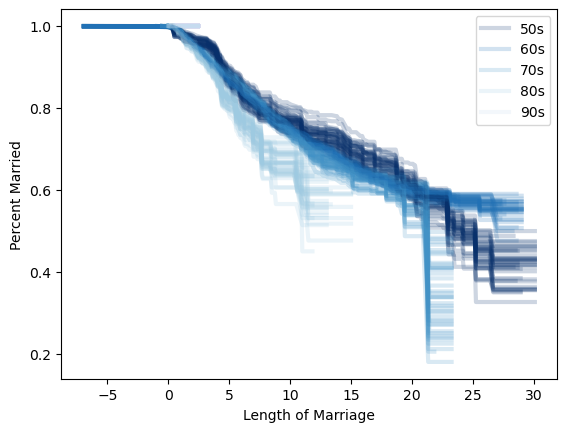

In [26]:
ResampleDivorceCurveDec([married6, married7])